# EDA for Freshflow's Time Series challenge

## Import of modules

In [1]:
!pip install pandas_profiling -q --user

In [31]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

## Read data

In [20]:
dataset = pd.read_csv('data.csv', index_col=0)
dataset.info()
dataset.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 0 to 1877
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     1878 non-null   object 
 1   item_number             1878 non-null   int64  
 2   item_name               1878 non-null   object 
 3   purchase_price          1878 non-null   float64
 4   suggested_retail_price  1878 non-null   float64
 5   orders_quantity         1878 non-null   float64
 6   sales_quantity          1878 non-null   float64
 7   revenue                 926 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 132.0+ KB


day  item_number                       item_name  purchase_price  \
1868  2021-04-04     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1869  2021-04-04     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1870  2021-04-04     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   
1871  2021-04-04     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   
1872  2021-04-03     80317483       ROMA TOMATEN ES I 500G SF        0.978451   
1873  2021-04-03     80317483       ROMA TOMATEN ES I 500G SF        0.978451   
1874  2021-04-03     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1875  2021-04-03     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1876  2021-04-03     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   
1877  2021-04-03     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   

      suggested_retail_price  orders_quantity  sales_quantity  revenue  
1868                3.216415              0.0             0.0      NaN  
1869                3.216415              0.0             0.0      NaN  
1870                1.055314              0.0             0.0      NaN  
1871                1.055314              0.0             0.0      NaN  
1872                1.546338             40.0            17.0    25.33  
1873                1.546338             40.0            17.0    25.33  
1874                3.216415              0.0             2.0     5.98  
1875                3.216415              0.0             2.0     5.98  
1876                1.055314              0.0            23.0    22.77  
1877                1.055314              0.0            23.0    22.77

#### First conclusions:
#### · There are no columns with missing data except for the revenue.
#### · The revenue seems to be NaN when 'sales_quantity' is 0, so it can be imputated.
#### · Some columns' type must be changed (date and quantities).

### Change data types

In [5]:
dataset.day = pd.to_datetime(dataset.day)
dataset.orders_quantity = dataset.orders_quantity.astype(int)
dataset.sales_quantity = dataset.sales_quantity.astype(int)

In [6]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 0 to 1877
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   day                     1878 non-null   datetime64[ns]
 1   item_number             1878 non-null   int64         
 2   item_name               1878 non-null   object        
 3   purchase_price          1878 non-null   float64       
 4   suggested_retail_price  1878 non-null   float64       
 5   orders_quantity         1878 non-null   int32         
 6   sales_quantity          1878 non-null   int32         
 7   revenue                 926 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(1)
memory usage: 117.4+ KB


day  item_number                       item_name  purchase_price  \
0 2022-02-09     80317483       ROMA TOMATEN ES I 500G SF            0.92   
1 2022-02-09     80317483       ROMA TOMATEN ES I 500G SF            0.92   
2 2022-02-09     80101923  SL MANDARINEN BEH.ES I 750G GS            2.05   
3 2022-02-09     80101923  SL MANDARINEN BEH.ES I 750G GS            2.05   
4 2022-02-09     80028349      UH ZWIEBELN DE-HE I 1KG GS            0.64   

   suggested_retail_price  orders_quantity  sales_quantity  revenue  
0                    1.49                0              16    23.55  
1                    1.49                0              16    23.55  
2                    3.49                0               3    10.47  
3                    3.49                0               3    10.47  
4                    0.99                0              13    12.84

### Check for duplicated rows

In [7]:
# generate count statistics of duplicate entries
if len(dataset[dataset.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(dataset[dataset.duplicated()]))
    print(dataset[dataset.duplicated(keep=False)].sort_values(by=list(dataset.columns)).head())
else:
    print("No duplicated entries found")

No. of duplicated entries:  939
            day  item_number                       item_name  purchase_price  \
1876 2021-04-03     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   
1877 2021-04-03     80028349      UH ZWIEBELN DE-HE I 1KG GS        0.674928   
1874 2021-04-03     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1875 2021-04-03     80101923  SL MANDARINEN BEH.ES I 750G GS        1.991321   
1872 2021-04-03     80317483       ROMA TOMATEN ES I 500G SF        0.978451   

      suggested_retail_price  orders_quantity  sales_quantity  revenue  
1876                1.055314                0              23    22.77  
1877                1.055314                0              23    22.77  
1874                3.216415                0               2     5.98  
1875                3.216415                0               2     5.98  
1872                1.546338               40              17    25.33  


#### All rows are duplicated, so I will assume that this behavior is not intentional and repeated rows will be removed.



In [21]:
dataset.drop_duplicates(inplace=True)

## Analyse numeric data

### Statistical info

In [22]:
display(dataset.describe().T)

count          mean            std          min  \
item_number             939.0  8.014925e+07  122756.375515  80028349.00   
purchase_price          939.0  1.216796e+00       0.568281         0.52   
suggested_retail_price  939.0  1.941402e+00       0.936906         0.66   
orders_quantity         939.0  8.602769e+00      14.985951         0.00   
sales_quantity          939.0  8.235357e+00      11.514012         0.00   
revenue                 463.0  2.120778e+01      13.076098         1.49   

                                 25%           50%           75%          max  
item_number             8.002835e+07  8.010192e+07  8.031748e+07  80317483.00  
purchase_price          6.749275e-01  9.784507e-01  1.991321e+00         2.15  
suggested_retail_price  1.055314e+00  1.546338e+00  3.216415e+00         3.49  
orders_quantity         0.000000e+00  0.000000e+00  1.800000e+01       144.00  
sales_quantity          0.000000e+00  0.000000e+00  1.500000e+01        85.00  
revenue                 1.285500e+01  1.922000e+01  2.741000e+01        93.52

### Boxplots of numeric data

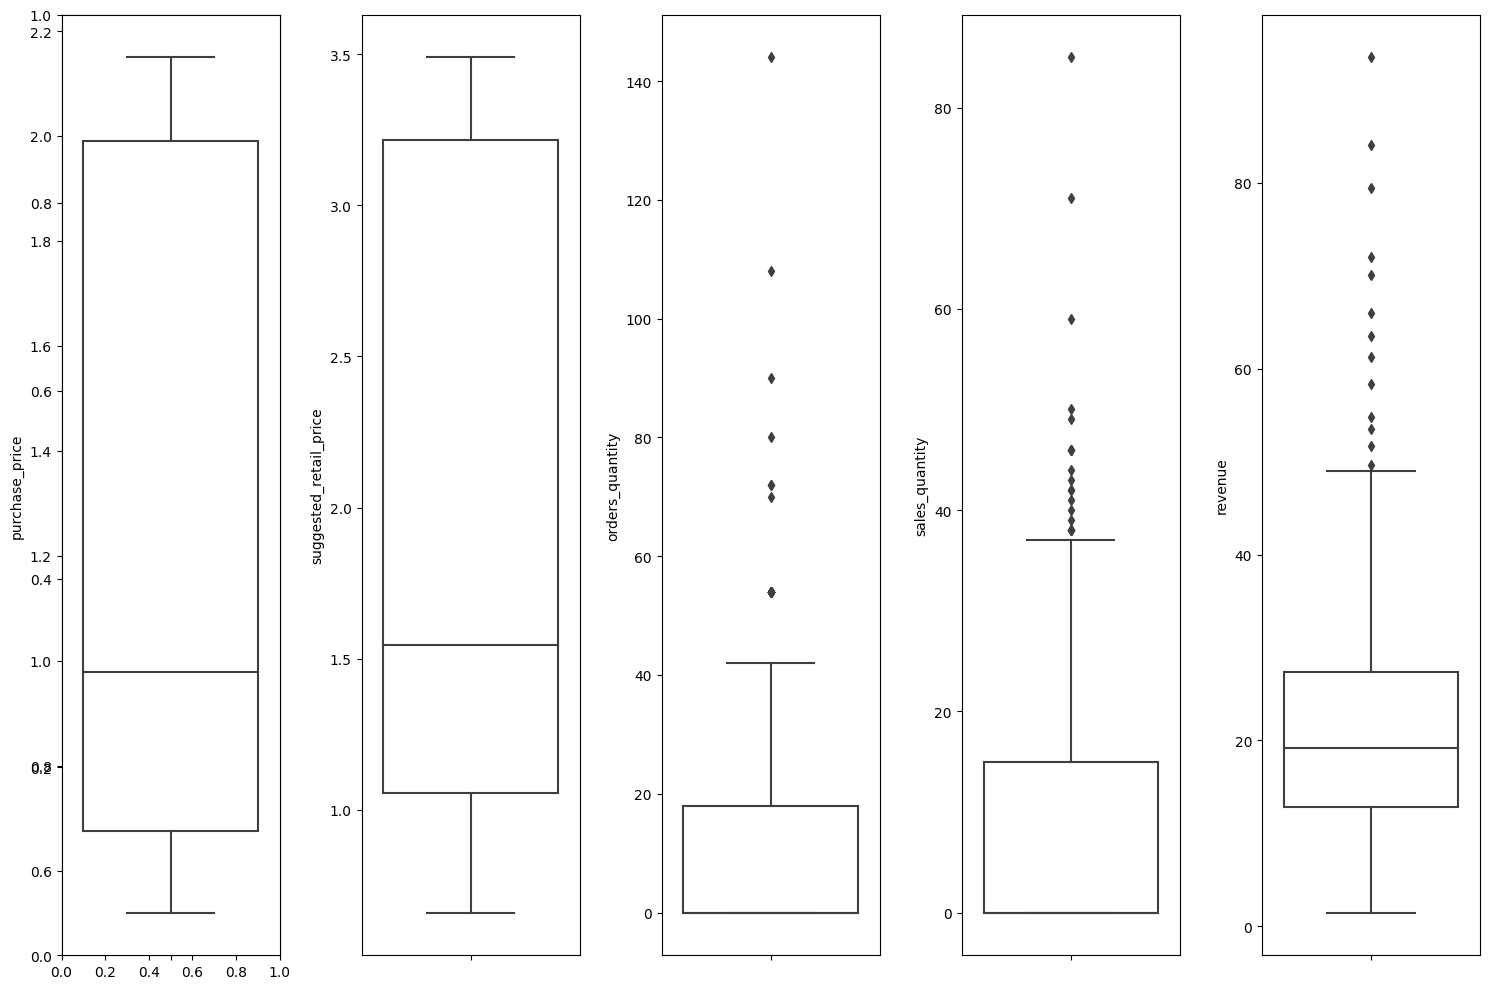

In [23]:
columns = dataset.select_dtypes(include=np.number).columns
columns = [i for i in columns if 'item_number' not in i] # Skip item identifier
figure = plt.figure(figsize=(15, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=dataset, boxprops={'facecolor': 'None'})
figure.tight_layout()
plt.show()

### Pairwise joint distribution of numeric data

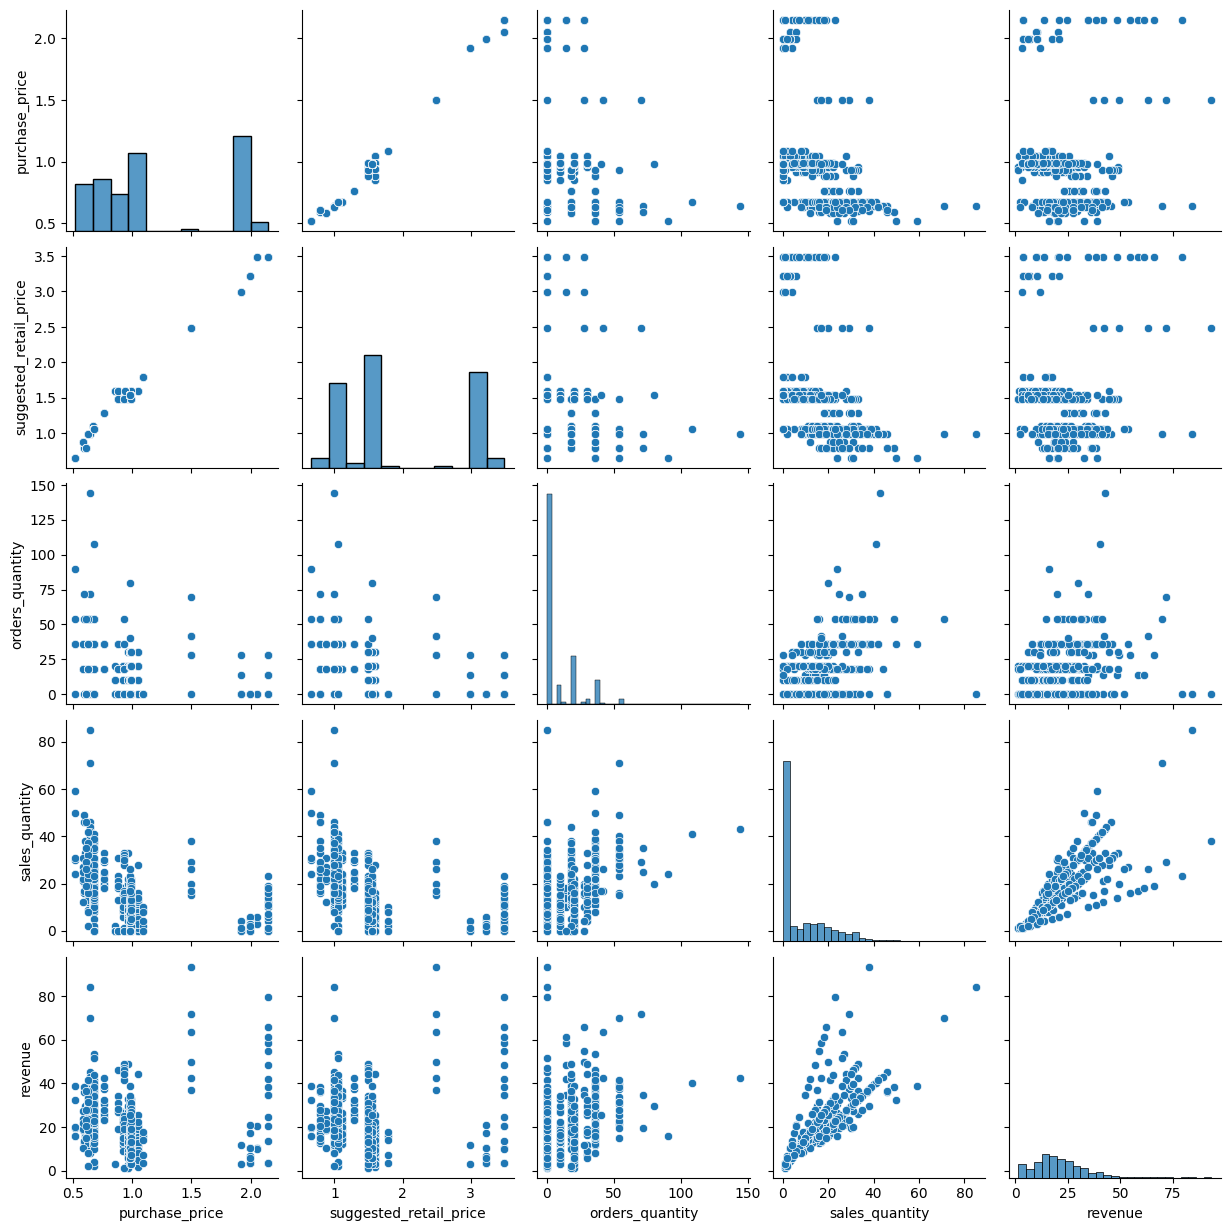

In [24]:
sns.pairplot(dataset.select_dtypes(include=np.number).iloc[:,1:])  # Skip item identifier column
plt.show()

#### Conclusions:
#### · No negative values in numerical data.
#### · Presence of outliers in columns 'orders_quantity', 'sales_quantity' and 'revenue'.
#### · As expected, some features are highly correlated, like 'purchase_price' and 'suggested_retail_price', 'sales_quantity' and 'revenue' or 'orders_quantity' and 'sales_quantity'.

## Plot time series data

### Plot daily data

In [25]:
for col in dataset.select_dtypes(include='datetime64').columns:
    for col_num in dataset.select_dtypes(include=np.number).columns[1:]:
        aux_df = dataset.copy()
        aux_df = aux_df.set_index(col)
        resampled = aux_df.resample('D').sum(numeric_only=False)
        ax = resampled[[col_num]].plot()
        ax.set_ylim(bottom=0)
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.show()
            

### Plot monthly data

In [26]:
for col in dataset.select_dtypes(include='datetime64').columns:
    for col_num in dataset.select_dtypes(include=np.number).columns[1:]:
        aux_df = dataset.copy()
        aux_df = aux_df.set_index(col)
        resampled = aux_df.resample('M').sum(numeric_only=False)
        ax = resampled[[col_num]].plot()
        ax.set_ylim(bottom=0)
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.show()

## Pandas profiling

In [27]:
profile = ProfileReport(dataset, tsmode=True, sortby="day")
profile.to_file('profile_report.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Deep analysis of trend and seasonality of 'sales_quantity'

Text(0.5, 1.0, 'Decomposition Plots')

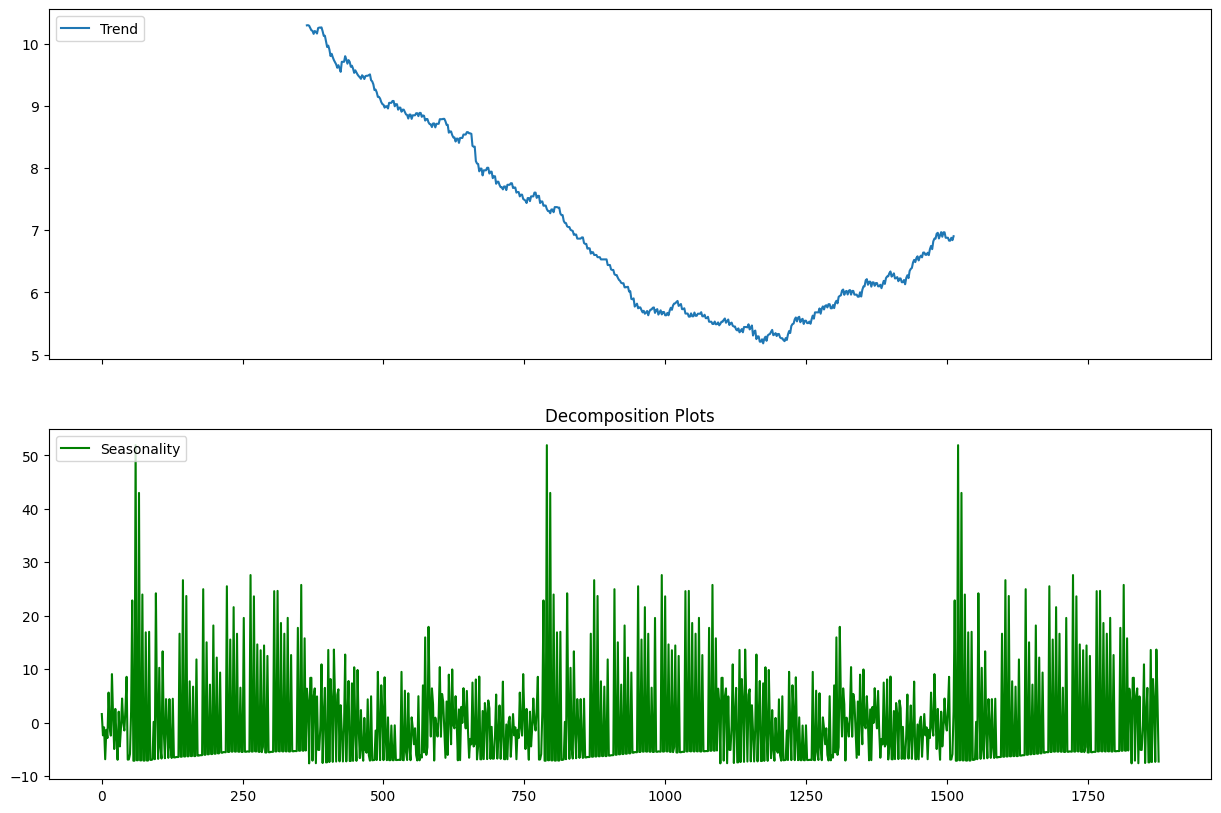

In [33]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)
decomposition= seasonal_decompose(dataset.sales_quantity, model = 'additive', period=365)
estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
axes[1].legend(loc='upper left');

axes[0].plot(estimated_trend, label='Trend')
axes[0].legend(loc='upper left')
plt.title('Decomposition Plots')